In [230]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

In [65]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [87]:
def polarity_scores_roberta(text):
    labels = [-1, 0, 1]
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    i, = np.where(scores == scores.max())
    return scores_dict, labels[i[0]]

## Bitcoin

In [190]:
btc_df = pd.read_csv(f'BTC_Tweets.csv', index_col=0)

In [191]:
btc_df.head()

,Date,Retweet,Reply,Likes,Tweet
0,2021-08-01 12:14:58+00:00,2125,1146,14393,A node is an altar to truth. A wallet is a wea...
1,2021-08-01 06:52:59+00:00,2125,484,13517,"#bitcoin July closing price $41,490 ... it bou..."
2,2021-08-01 05:33:57+00:00,3259,952,12759,Bitcoin mining is really bad for the environme...
3,2021-08-01 05:05:19+00:00,1786,27,11749,You can't stop #bitcoin by talking badly about...
4,2021-08-01 20:30:14+00:00,6714,4689,10799,📣 Wierd Finance Airdrop is live!\n\n🏆 Reward f...


In [193]:
roberta_result = {}
classes = []
for i, row in tqdm(btc_df.iterrows(), total=len(btc_df)):
    text = row['Tweet']
    result = polarity_scores_roberta(text)
    roberta_result[i] = {**result[0]}
    classes.append(result[1])

100%|██████████| 17835/17835 [33:13<00:00,  8.95it/s] 


In [197]:
btc_df = btc_df.join(pd.DataFrame(roberta_result).T)
btc_df['classes'] = classes

btc_df.head()

,Date,Retweet,Reply,Likes,Tweet,classes,roberta_neg,roberta_neu,roberta_pos
0,2021-08-01 12:14:58+00:00,2125,1146,14393,A node is an altar to truth. A wallet is a wea...,0,0.029172,0.711070,0.259758
1,2021-08-01 06:52:59+00:00,2125,484,13517,"#bitcoin July closing price $41,490 ... it bou...",1,0.007346,0.378768,0.613885
2,2021-08-01 05:33:57+00:00,3259,952,12759,Bitcoin mining is really bad for the environme...,-1,0.941482,0.055367,0.003151
3,2021-08-01 05:05:19+00:00,1786,27,11749,You can't stop #bitcoin by talking badly about...,-1,0.561230,0.378262,0.060508
4,2021-08-01 20:30:14+00:00,6714,4689,10799,📣 Wierd Finance Airdrop is live!\n\n🏆 Reward f...,0,0.007581,0.673813,0.318606


In [210]:
btc_df.to_csv('sentiment_btc.csv')

In [220]:
btc_df['Date'] = pd.to_datetime(btc_df['Date']).dt.date
btc_df1 = btc_df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

In [221]:
dff = pd.read_csv(r'BTC_tweet_perday.csv', index_col=0)

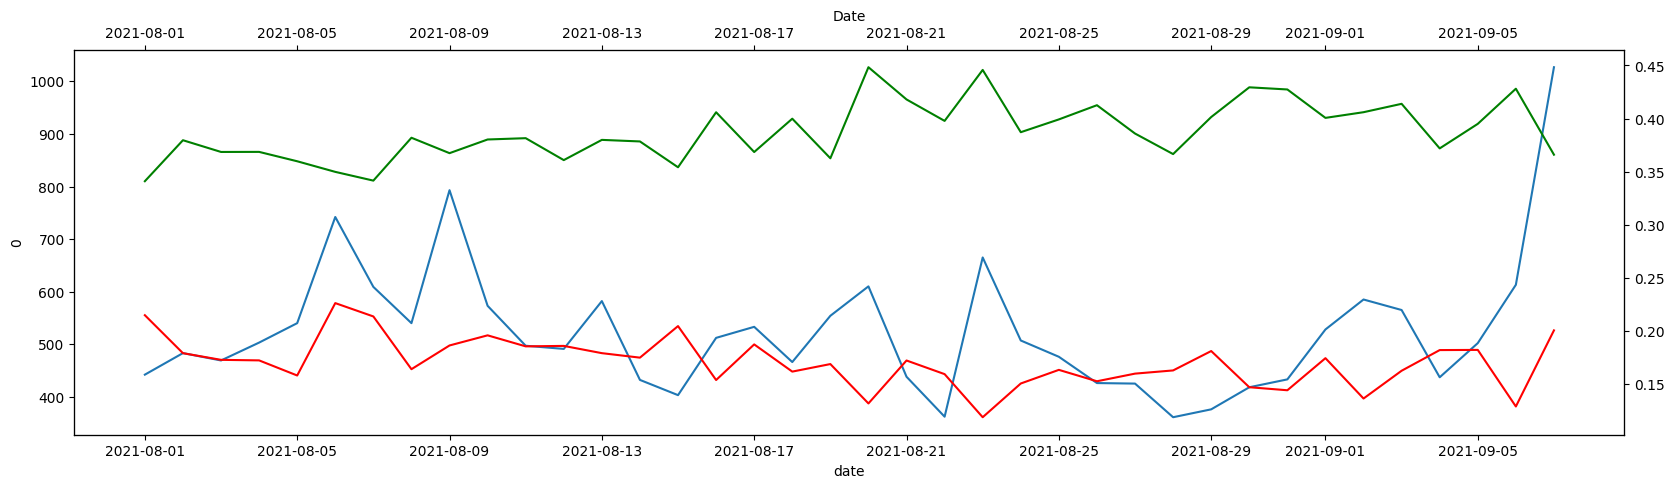

In [229]:
date = []
for i in range(38):
    date.append(pd.to_datetime('2021-08-01') + pd.Timedelta(days=i))

dff['date'] = date
fig = plt.figure(figsize=(20, 5))
ax = sns.lineplot(x='date', y='0', data=dff)
ax2 = ax.twinx()
ax3 = ax2.twiny()
ax2 = sns.lineplot(x='Date', y='roberta_neg', data=btc_df1, color='r')
ax3 = sns.lineplot(x='Date', y='roberta_pos', data=btc_df1, color='g')

plt.show()

## Ethereum

In [183]:
eth_df = pd.read_csv(f'ETH_Tweets.csv', index_col=0)

In [184]:
eth_df.head()

,Date,Retweet,Reply,Likes,Tweet
0,2021-08-01 20:30:14+00:00,6714,4689,10799,📣 Wierd Finance Airdrop is live!\n\n🏆 Reward f...
1,2021-08-01 13:00:36+00:00,2360,77,10282,Crypto bro learns a valuable lesson about nfts...
2,2021-08-01 01:18:44+00:00,13506,9008,7084,"$500 CRYPTO || 6,8 JUTA IDR\n|| one winner || ..."
3,2021-08-01 06:31:45+00:00,13546,5853,6982,"$500 CRYPTO || 6,8 JUTA IDR\n|| one winner || ..."
4,2021-08-01 13:33:00+00:00,323,280,6536,Only future #crypto millionaires or billionair...


In [185]:
roberta_result = {}
classes = []
for i, row in tqdm(eth_df.iterrows(), total=len(eth_df)):
    text = row['Tweet']
    result = polarity_scores_roberta(text)
    roberta_result[i] = {**result[0]}
    classes.append(result[1])

100%|██████████| 16170/16170 [31:41<00:00,  8.50it/s]


In [188]:
eth_df = eth_df.join(pd.DataFrame(roberta_result).T)
eth_df['classes'] = classes

,Date,Retweet,Reply,Likes,Tweet,classes,roberta_neg,roberta_neu,roberta_pos
0,2021-08-01 20:30:14+00:00,6714,4689,10799,📣 Wierd Finance Airdrop is live!\n\n🏆 Reward f...,0,0.007581,0.673813,0.318606
1,2021-08-01 13:00:36+00:00,2360,77,10282,Crypto bro learns a valuable lesson about nfts...,0,0.017721,0.492217,0.490062
2,2021-08-01 01:18:44+00:00,13506,9008,7084,"$500 CRYPTO || 6,8 JUTA IDR\n|| one winner || ...",0,0.042528,0.799713,0.157758
3,2021-08-01 06:31:45+00:00,13546,5853,6982,"$500 CRYPTO || 6,8 JUTA IDR\n|| one winner || ...",0,0.040356,0.834890,0.124755
4,2021-08-01 13:33:00+00:00,323,280,6536,Only future #crypto millionaires or billionair...,1,0.002724,0.090555,0.906721


In [189]:
eth_df = df.copy()
eth_df.head()

,Date,Retweet,Reply,Likes,Tweet,classes,roberta_neg,roberta_neu,roberta_pos
0,2021-08-01 20:30:14+00:00,6714,4689,10799,📣 Wierd Finance Airdrop is live!\n\n🏆 Reward f...,0,0.007581,0.673813,0.318606
1,2021-08-01 13:00:36+00:00,2360,77,10282,Crypto bro learns a valuable lesson about nfts...,0,0.017721,0.492217,0.490062
2,2021-08-01 01:18:44+00:00,13506,9008,7084,"$500 CRYPTO || 6,8 JUTA IDR\n|| one winner || ...",0,0.042528,0.799713,0.157758
3,2021-08-01 06:31:45+00:00,13546,5853,6982,"$500 CRYPTO || 6,8 JUTA IDR\n|| one winner || ...",0,0.040356,0.834890,0.124755
4,2021-08-01 13:33:00+00:00,323,280,6536,Only future #crypto millionaires or billionair...,1,0.002724,0.090555,0.906721


In [195]:
eth_df.to_csv('sentiment_eth.csv')

In [231]:
eth_df['Date'] = pd.to_datetime(eth_df['Date']).dt.date
eth_df1 = eth_df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

In [232]:
dff = pd.read_csv(r'ETH_tweet_perday.csv', index_col=0)

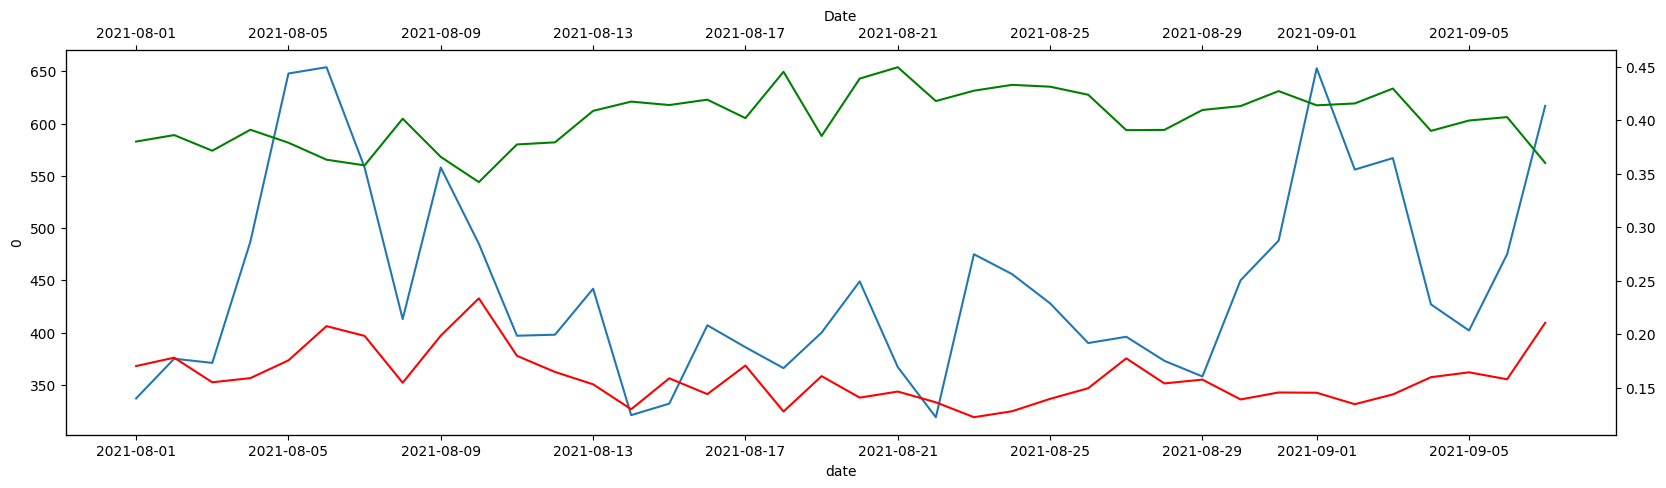

In [236]:
date = []
for i in range(38):
    date.append(pd.to_datetime('2021-08-01') + pd.Timedelta(days=i))

dff['date'] = date
fig = plt.figure(figsize=(20, 5))
ax = sns.lineplot(x='date', y='0', data=dff)
ax2 = ax.twinx()
ax3 = ax2.twiny()
ax2 = sns.lineplot(x='Date', y='roberta_neg', data=eth_df1, color='r')
ax3 = sns.lineplot(x='Date', y='roberta_pos', data=eth_df1, color='g')

plt.show()